## RGS14 Sleep state transition research based on aperiodic signal 
### Part 1: Process data

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as io
import math

from collections import Counter
from scipy import signal, io
from scipy.ndimage import gaussian_filter
from fooof import FOOOF
import os

### 1.1 Load in all data
- Data is stored locally 
- Folders for each condition HomeCageHC / OverlappingOR /...
- Each condition contains folder Rat1 till Rat9
- Each rat folder contains `HPC_100.continuous.mat`, `PFC_100.continuous.mat`, `states.mat`


In [9]:
BASE_DATA_DIR = "./data"
CONDITIONS_DIR_NAMES = ['HomeCageHC', "OverlappingOR"] # TODO add last 2 
CONTROL_RATS = [1,2,6,9]
RGS_RATS = [3,4,7,8]

# Initialize the data structure
rats_data = {
    condition: {
        'rgs_positive': [],
        'rgs_negative': []
    }
    for condition in CONDITIONS_DIR_NAMES
}

for condition in CONDITIONS_DIR_NAMES:
    for rat_index in CONTROL_RATS:
        folder_dir = f"{BASE_DATA_DIR}/{condition}/Rat{rat_index}/Post-Trial5"
        print(f'Loading Rat{rat_index} data condition {condition}, DIR: {folder_dir}')
        states_mat = io.loadmat(f'{folder_dir}/states.mat')
        hpc_mat = io.loadmat(f'{folder_dir}/HPC_100.continuous.mat')
        pfc_mat = io.loadmat(f'{folder_dir}/PFC_100.continuous.mat')

        data_object = {
            'number': rat_index,
            'states': states_mat['states'].ravel(),
            'hpc': hpc_mat['HPC'].ravel(),
            'pfc': pfc_mat['PFC'].ravel(),
        }
        rats_data[condition]['rgs_negative'].append(data_object)

    # Load RGS rats data (RGS positive)
    for rat_index in RGS_RATS:
        folder_dir = f"{BASE_DATA_DIR}/{condition}/Rat{rat_index}/Post-Trial5"
        print(f'Loading Rat{rat_index} data condition {condition}, DIR: {folder_dir}')
        states_mat = io.loadmat(f'{folder_dir}/states.mat')
        hpc_mat = io.loadmat(f'{folder_dir}/HPC_100.continuous.mat')
        pfc_mat = io.loadmat(f'{folder_dir}/PFC_100.continuous.mat')

        data_object = {
            'number': rat_index,
            'states': states_mat['states'].ravel(),
            'hpc': hpc_mat['HPC'].ravel(),
            'pfc': pfc_mat['PFC'].ravel(),
        }
        rats_data[condition]['rgs_positive'].append(data_object)

print(f'Successfully loaded data for conditions: {CONDITIONS_DIR_NAMES}')


Loading Rat1 data condition HomeCageHC, DIR: ./data/HomeCageHC/Rat1/Post-Trial5
Loading Rat2 data condition HomeCageHC, DIR: ./data/HomeCageHC/Rat2/Post-Trial5
Loading Rat6 data condition HomeCageHC, DIR: ./data/HomeCageHC/Rat6/Post-Trial5
Loading Rat9 data condition HomeCageHC, DIR: ./data/HomeCageHC/Rat9/Post-Trial5
Loading Rat3 data condition HomeCageHC, DIR: ./data/HomeCageHC/Rat3/Post-Trial5
Loading Rat4 data condition HomeCageHC, DIR: ./data/HomeCageHC/Rat4/Post-Trial5
Loading Rat7 data condition HomeCageHC, DIR: ./data/HomeCageHC/Rat7/Post-Trial5
Loading Rat8 data condition HomeCageHC, DIR: ./data/HomeCageHC/Rat8/Post-Trial5
Loading Rat1 data condition OverlappingOR, DIR: ./data/OverlappingOR/Rat1/Post-Trial5
Loading Rat2 data condition OverlappingOR, DIR: ./data/OverlappingOR/Rat2/Post-Trial5
Loading Rat6 data condition OverlappingOR, DIR: ./data/OverlappingOR/Rat6/Post-Trial5
Loading Rat9 data condition OverlappingOR, DIR: ./data/OverlappingOR/Rat9/Post-Trial5
Loading Rat3 dat

### 1.2 Analysing all state transition and frequency

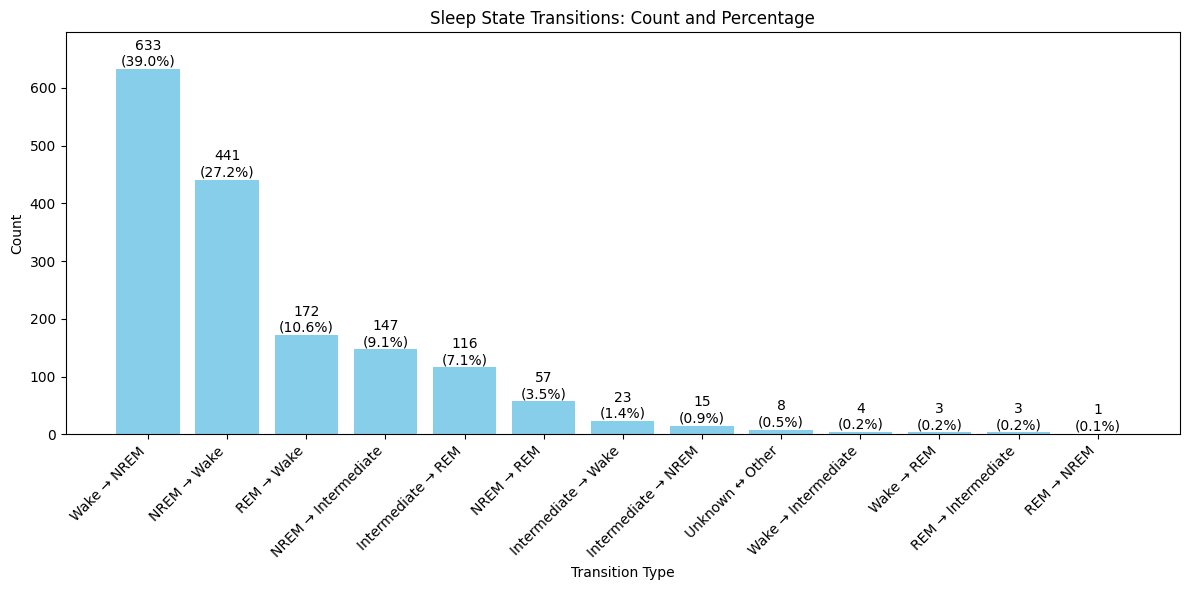

In [31]:
# handler in case there are nan of unknown(0) values in the data
def is_unknown(state):

    return (state == 0) or (str(state).lower() == 'nan') or (isinstance(state, float) and math.isnan(state))

def transition_label(from_state, to_state):
    from_label = state_map.get(from_state, 'Unknown')
    to_label = state_map.get(to_state, 'Unknown')
    if is_unknown(from_state) or is_unknown(to_state) or from_label == 'Unknown' or to_label == 'Unknown':
        return 'Unknown ↔ Other'
    else:
        return f"{from_label} → {to_label}"

grouped_transitions = Counter()
for (from_state, to_state), count in global_transition_counts.items():
    if from_state != to_state:
        label = transition_label(from_state, to_state)
        grouped_transitions[label] += count

sorted_transitions = sorted(grouped_transitions.items(), key=lambda x: x[1], reverse=True)
total_transitions = sum(count for _, count in sorted_transitions)

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(sorted_transitions)), [c for _, c in sorted_transitions], color='skyblue')

for i, bar in enumerate(bars):
    count = sorted_transitions[i][1]
    pct = (count / total_transitions) * 100
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom')

# add small padding at the top so % doenst cuttoff
plt.ylim(0, max(count for _, count in sorted_transitions) * 1.1)

plt.title('Sleep State Transitions: Count and Percentage')
plt.xlabel('Transition Type')
plt.ylabel('Count')
plt.xticks(range(len(sorted_transitions)), [lbl for lbl, _ in sorted_transitions], rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 1.2 Save FOOF exponents
- Calculating FOOF exponents for the post-trials is quite slow
- Therefore I bulk calculate them for each PostTrial and save them in `./data/FoofExponents` 
- Parameters taken from [The Temporal Dynamics of Aperiodic Neural Activity Track Changes in Sleep Architecture](https://www.biorxiv.org/content/10.1101/2024.01.25.577204v1.full)

In [ ]:
# parameters from paper
sample_freq = 1000
adc_scale_uv = 0.195
window_sec = 15
noverlap = window_sec * sample_freq // 2
exponent_range = (1, 30)

def extract_foof_exponents(eeg):
    data = eeg.astype(np.float64) * adc_scale_uv
    nperseg = window_sec * sample_freq
    nfft = max(2048, 1 << (nperseg - 1).bit_length())
    f, t, Pxx = signal.spectrogram(
        data, sample_freq, window='hamming', nperseg=nperseg,
        noverlap=noverlap, nfft=nfft, detrend='constant',
        scaling='density', mode='psd'
    )
    times = t + window_sec / 2
    exponents = []

    for col in range(Pxx.shape[1]):
        fm = FOOOF(aperiodic_mode='fixed', verbose=False)
        try:
            fm.fit(f, Pxx[:, col], exponent_range)
            exponents.append(fm.aperiodic_params_[1])
        except Exception:
            exponents.append(np.nan)

    return times, np.array(exponents)

def save_rat_features(rat_data, group, condition, region, out_base_dir='./data/FoofExponents'):
    rat_id = rat_data['number']
    eeg = rat_data[region.lower()]  # 'hpc' or 'pfc'
    out_dir = os.path.join(out_base_dir, condition)
    os.makedirs(out_dir, exist_ok=True)
    out_file = os.path.join(out_dir, f"FOOF_Rat{rat_id}_{region}.npz")
    if os.path.exists(out_file):
        print(f"[SKIP] {out_file} already exists.")
        return
    times, exponents = extract_foof_exponents(eeg)
    np.savez(out_file, rat_id=rat_id, group=group, region=region,
             times=times, exponents=exponents)
    print(f"[✓] Saved FOOF bins for Rat {rat_id} ({group}, {condition}, {region}) to {out_file}")

# Loop over all conditions, groups, rats, and regions
for condition in CONDITIONS_DIR_NAMES:
    for group, group_key in [('RGS', 'rgs_positive'), ('Control', 'rgs_negative')]:
        for rat_data in rats_data[condition][group_key]:
            for region in ['HPC', 'PFC']:
                try:
                    save_rat_features(rat_data, group, condition, region)
                except Exception as e:
                    print(f"[X] Failed for Rat {rat_data['number']} ({group}, {condition}, {region}): {e}")

[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat3_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat3_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat4_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat4_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat7_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat7_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat8_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat8_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat1_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat1_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat2_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat2_PFC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat6_HPC.npz already exists.
[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat6_PF